In [1]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal

In [2]:
# setting hyperparameters
S = 10 # sessions
T = 500 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

In [3]:
# True Transition Matrix
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
print("True Transition Matrix P")
print(trueP)

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


Session indicies
[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


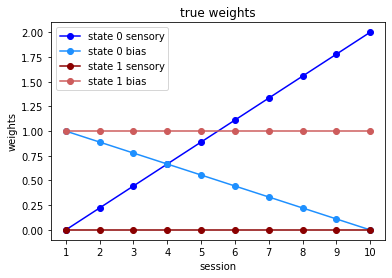

(5000, 2, 2, 2)


In [4]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,0] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)
plotting_weights(trueW,sessInd,'true weights')
print(trueW.shape)

In [5]:
# initialize object
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)

In [6]:
# simualating data from true weight and transition matrices
# simX, simY, simZ = dGLM_HMM.simulate_data(trueW, trueP, sessInd, save=True)

# loading from previously simulateed
simX = np.load('../data/simX.npy')
simY = np.load('../data/simY.npy')
simZ = np.load('../data/simZ.npy')
simPhi = dGLM_HMM.observation_probability(simX, trueW)

In [7]:
alpha, ct, ll = dGLM_HMM.forward_pass(simY[2000:2500], trueP, simPhi[2000:2500,:,:])
beta = dGLM_HMM.backward_pass(simY[2000:2500,], trueP, simPhi[2000:2500,:,:], ct)
gamma, zeta = dGLM_HMM.posteriorLatents(simY[2000:2500], trueP, simPhi[2000:2500,:], alpha, beta, ct)
print(zeta)

[[[0.82373902 0.01056502]
  [0.01866103 0.14703493]]

 [[0.81676383 0.02563622]
  [0.00777027 0.14982968]]

 [[0.80834669 0.01618741]
  [0.01319071 0.16227519]]

 ...

 [[0.92985242 0.01005515]
  [0.00786218 0.05223024]]

 [[0.92807136 0.00964324]
  [0.00843597 0.05384942]]

 [[0.91212678 0.02438055]
  [0.00364466 0.05984801]]]


In [8]:
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['normal', (0,1)])

In [9]:
dGLM_HMM.weight_loss_function(np.ndarray.flatten(trueW[2000,:,:,0]), simX[2000:2500], simY[2000:2500], gamma, trueW[1500], trueW[2500], reshapeSigma(0.5,2,2))

290.0076127251935

In [7]:
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(simX, simY,  initP, initW, sigma=reshapeSigma(0.1, K, D), sessInd=sessInd, pi0=None, maxIter=5, tol=1e-3) # fit the model
            

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_

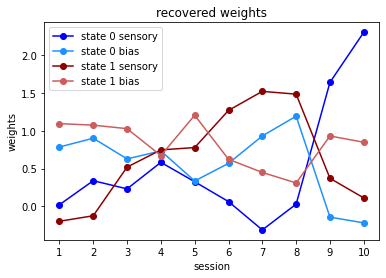

In [14]:
plotting_weights(checkW, sessInd, 'recovered weights')

In [8]:
sigmaList = [0.1,1,10]
sigmaList = [reshapeSigma(s, K, D) for s in sigmaList]
weightDistributionList = [['uniform', (-2,2)], ['normal', (0,1)]]
inits = 10 # set the number of initializations
maxiter = 250 #250
# store values for each model
allLl = np.zeros((len(sigmaList),len(weightDistributionList),inits,maxiter))
allP = np.zeros((len(sigmaList),len(weightDistributionList),inits, K,K))
allW = np.zeros((len(sigmaList),len(weightDistributionList),inits,N,K,D,C))
for ind1 in range(0, len(sigmaList)):
    for ind2 in range(0, len(weightDistributionList)):
        for ind3 in range(0, inits):
            print(ind3)
            # fit the model for each 
            initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=weightDistributionList[ind2]) # initialize the model parameters
            allP[ind1,ind2,ind3], allW[ind1,ind2,ind3], allLl[ind1,ind2,ind3] = dGLM_HMM.fit(simX, simY,  initP, initW, sigma=sigmaList[ind1], sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model

np.save('../data/fittedLl', allLl)
np.save('../data/fittedW', allW)
np.save('../data/fittedP', allP)       

0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_

1


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

2


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarni

3


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

4


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarni

5


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_

6


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_

7


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

8


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

9


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_

0


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

1


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

2


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

3


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarni

4


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/cod

5


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarni

6


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

7


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_

8


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarni

9


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:365: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:368: RuntimeWarning: divide by zero encountered in log
  lf += np.log(rv.pdf(currentW[k,:]))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimi

0


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

1


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

2


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

3


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

4


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


5
6


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

7


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


8


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

9
0


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

1
2


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


3


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

4


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


5


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


6


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


7


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

8


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

9


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

0


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


1


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

2


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

3


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

4


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

5


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

6


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

7


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


8


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

9


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

0


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


1


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

2


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

3


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


4
5


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

6


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

7


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

8


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / 

9


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


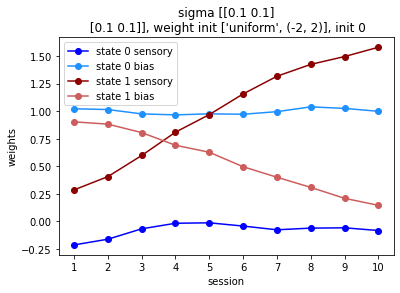

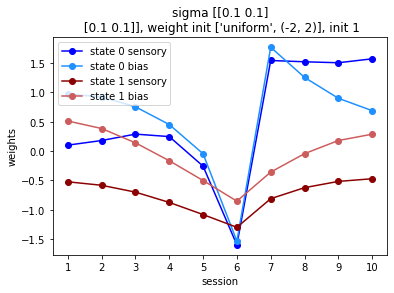

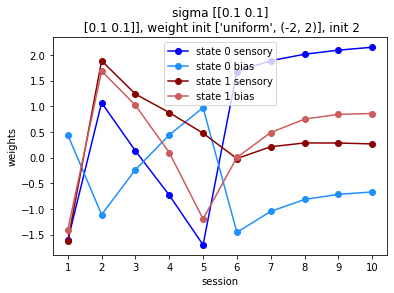

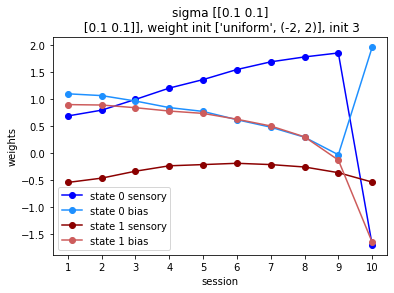

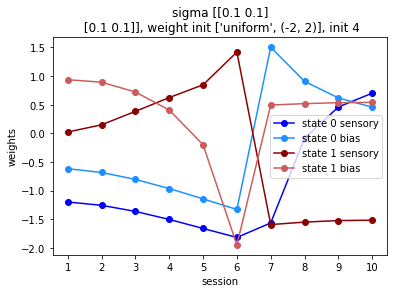

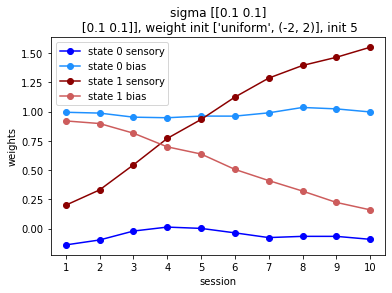

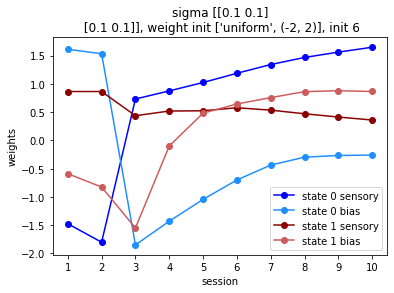

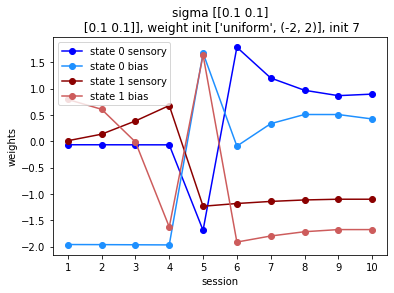

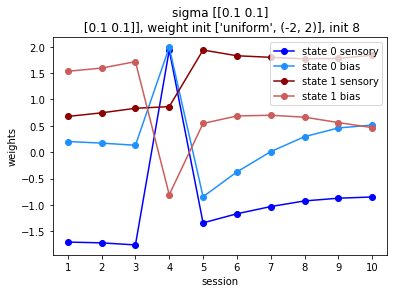

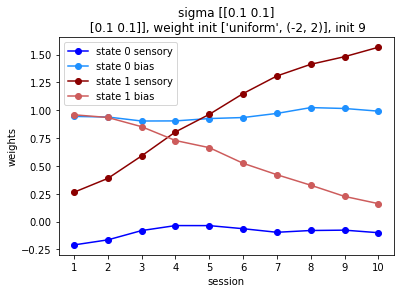

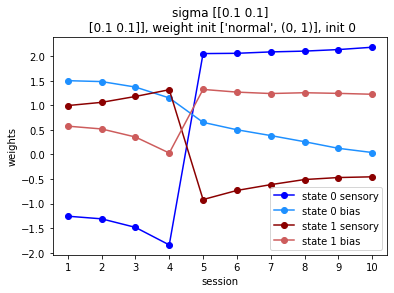

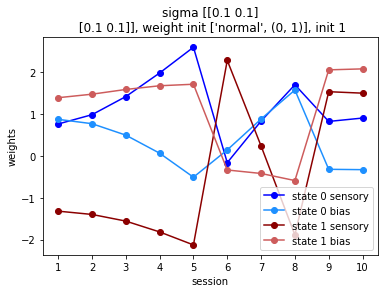

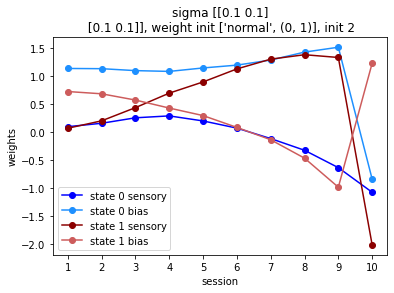

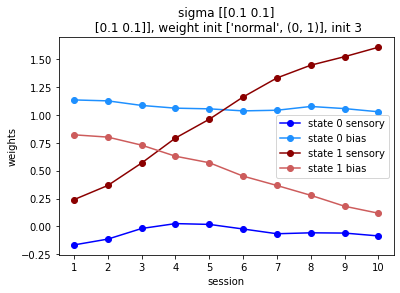

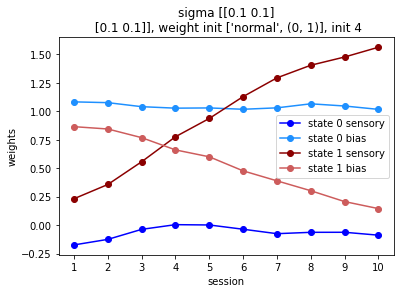

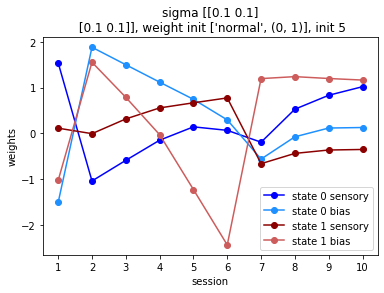

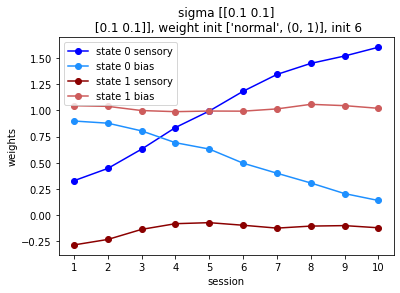

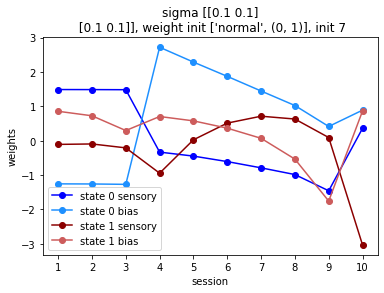

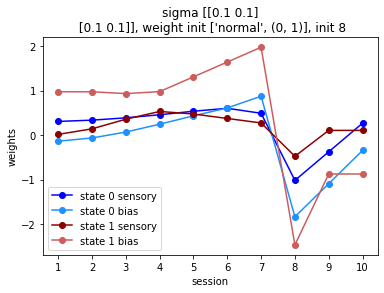

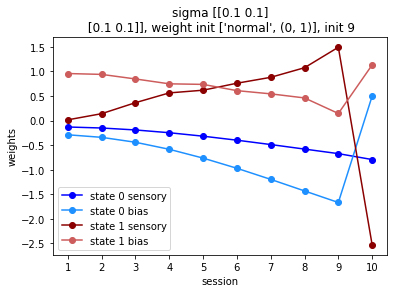

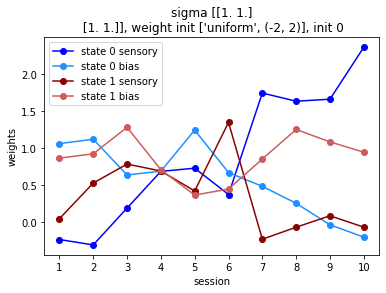

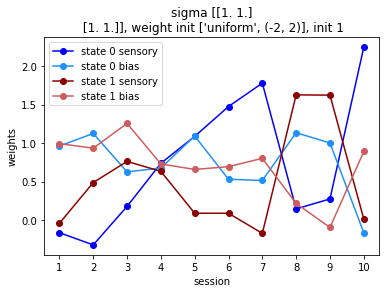

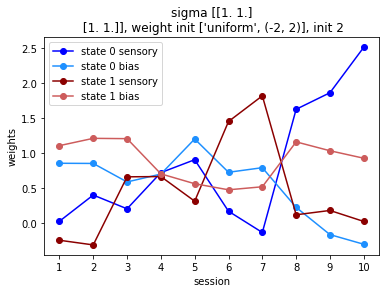

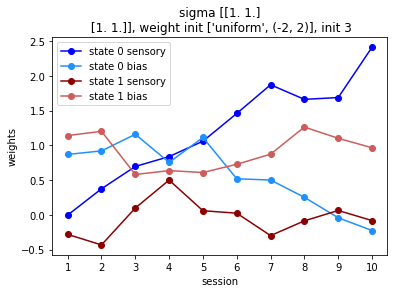

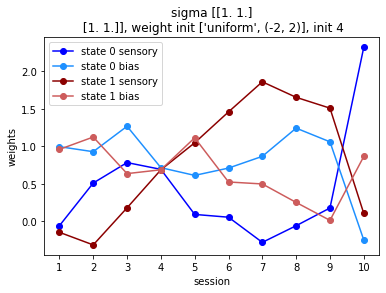

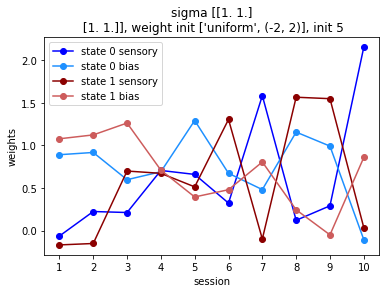

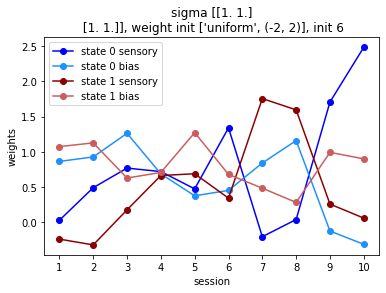

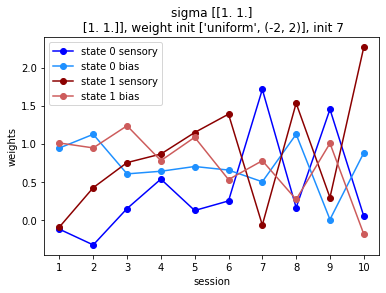

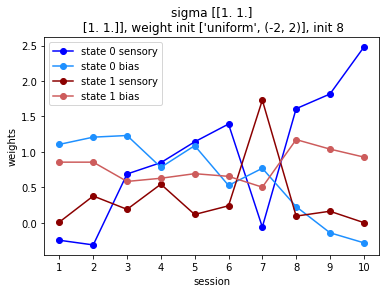

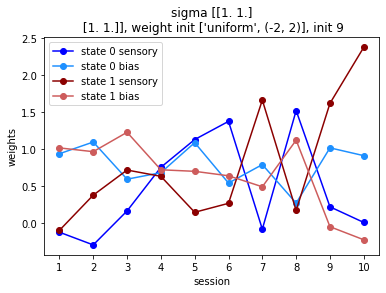

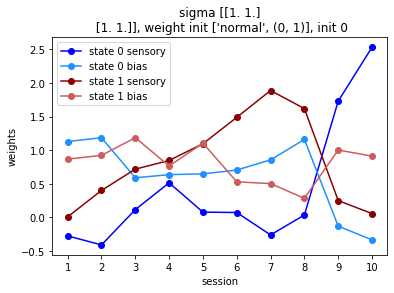

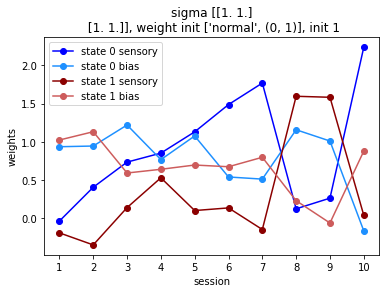

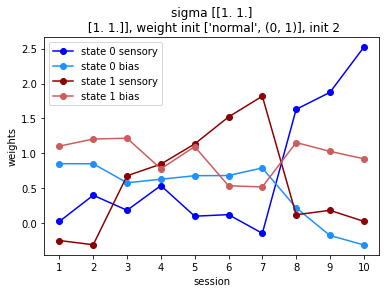

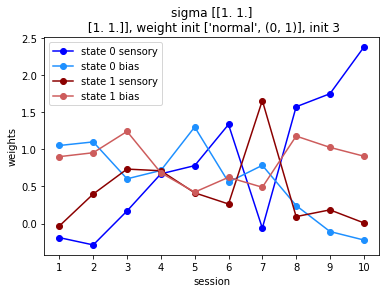

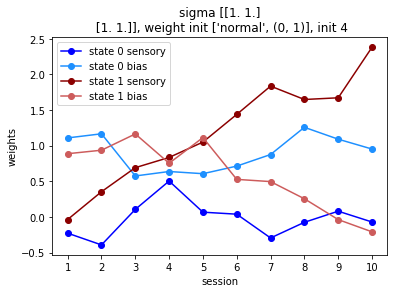

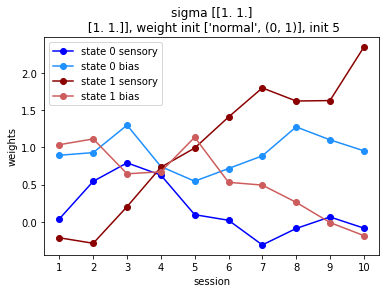

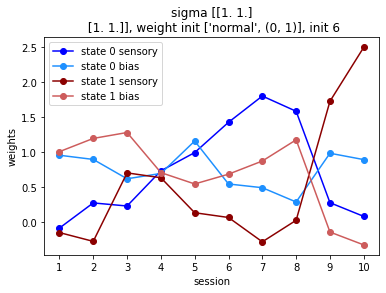

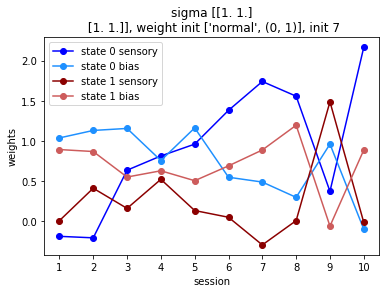

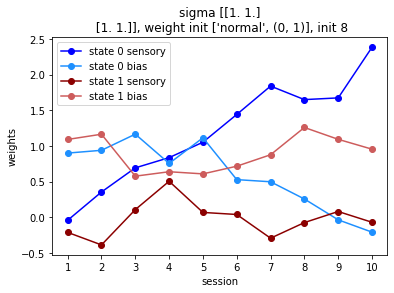

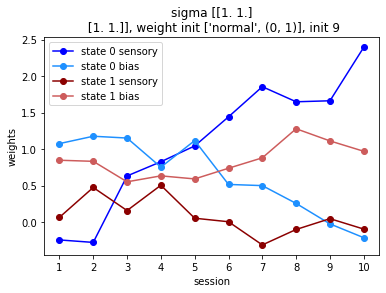

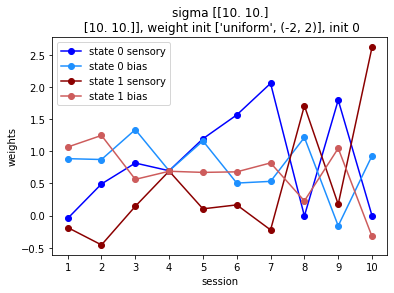

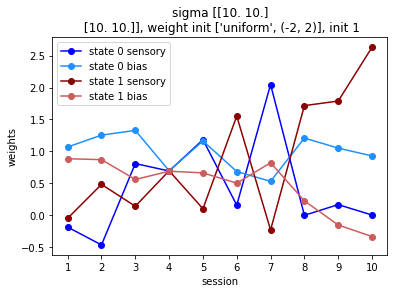

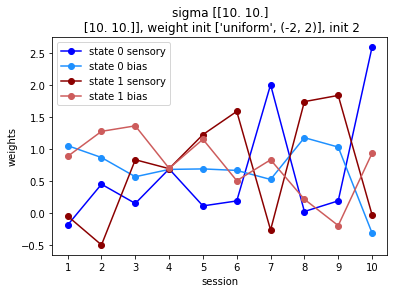

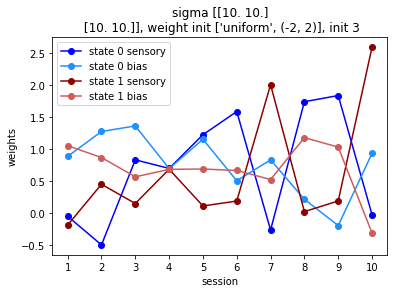

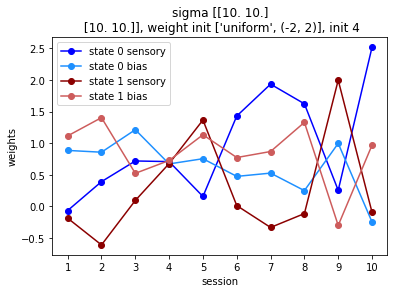

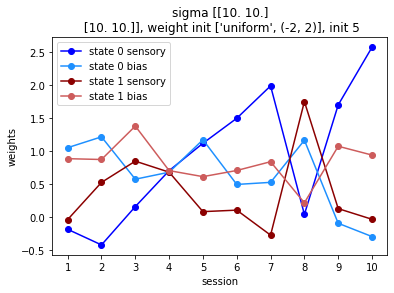

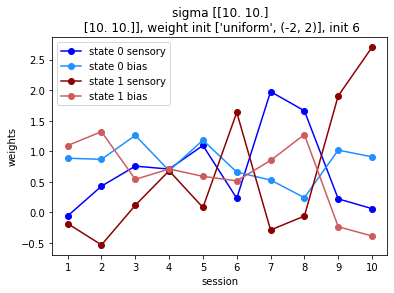

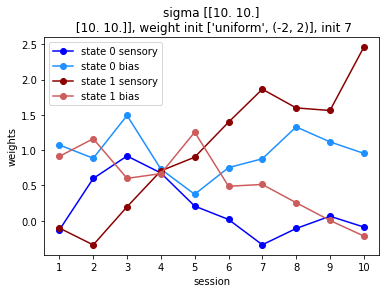

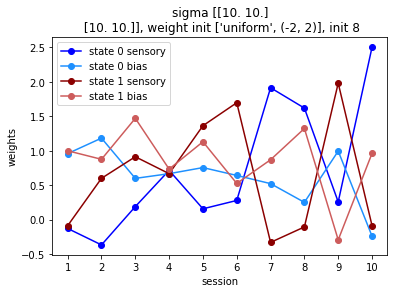

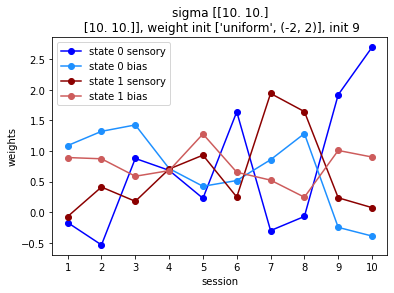

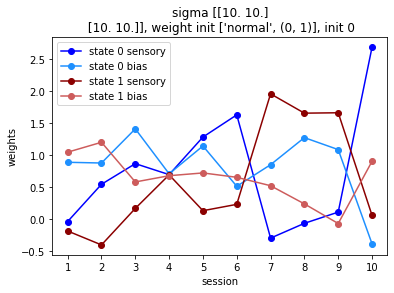

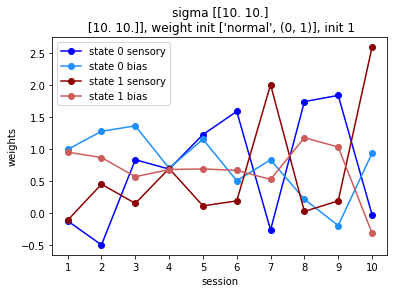

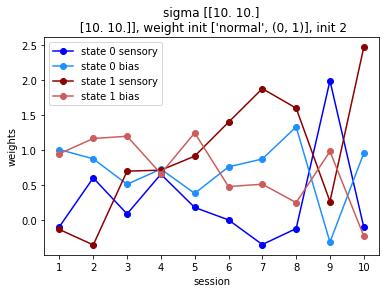

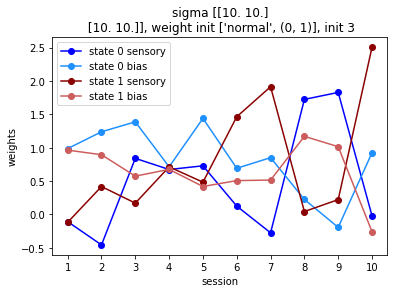

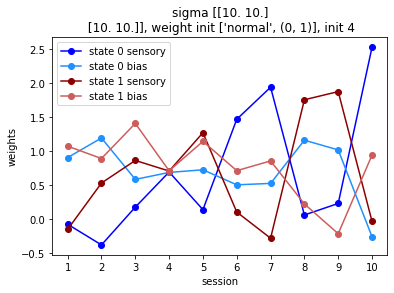

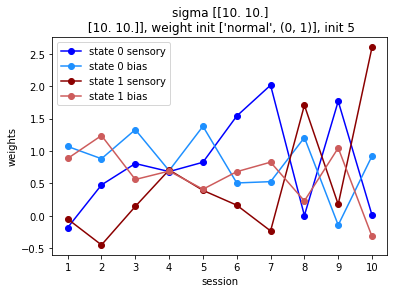

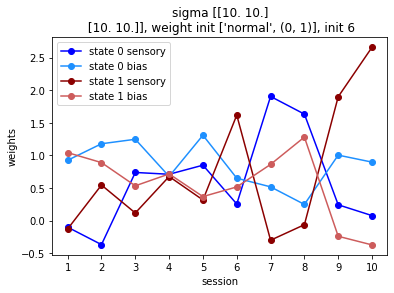

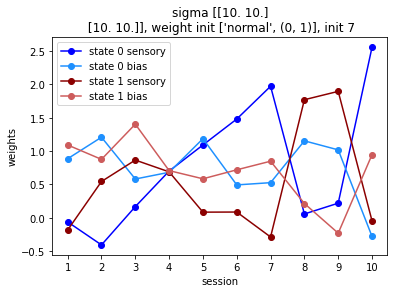

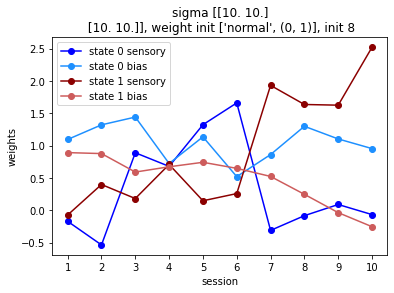

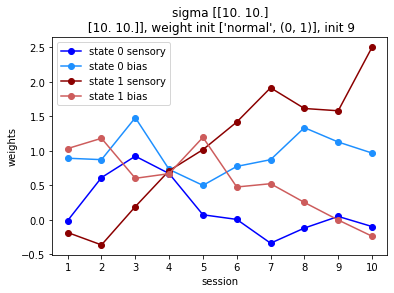

In [10]:
for ind1 in range(0, len(sigmaList)):
    for ind2 in range(0, len(weightDistributionList)):
        for ind3 in range(0, inits):
            plotting_weights(allW[ind1,ind2,ind3],sessInd,f'sigma {sigmaList[ind1]}, weight init {weightDistributionList[ind2]}, init {ind3}')

In [ ]:
# what is the perfect sigma for each state???


In [18]:
print(allLl.shape)
maxInd = np.argmax(allLl,axis=3)
print(allLl[tuple(maxInd)])
print(np.unravel_index(np.argmax(allLl, axis=None), allLl.shape))

(3, 2, 10, 250)


IndexError: index 41 is out of bounds for axis 0 with size 3

In [38]:
print(allLl[2,1,2,:])

[-3737.22966168 -2983.63449888 -2949.31693623 -2930.18639529
 -2919.49976224 -2913.73765169 -2911.21904121 -2909.87529763
 -2908.7924907  -2907.75432176 -2906.79335292 -2906.01287987
 -2905.44632971 -2905.04644149 -2904.75171852 -2904.52022828
 -2904.32871719 -2904.16467846 -2904.02101997 -2903.89339035
 -2903.77891897 -2903.67559084 -2903.58192186 -2903.49677106
 -2903.41922682 -2903.34853297 -2903.28404502 -2903.22519846
 -2903.17149092 -2903.12246683 -2903.07771256 -2903.03684939
 -2902.99953049 -2902.9654384  -2902.93428323 -2902.90579952
 -2902.87974608 -2902.85590289 -2902.83407034 -2902.81406716
 -2902.79572878 -2902.77890578 -2902.76346332 -2902.74927827
 -2902.73623952 -2902.72424582 -2902.71320584 -2902.70303638
 -2902.69366171 -2902.68501323 -2902.67702844 -2902.66965056
 -2902.66282814 -2902.65651387 -2902.65066517 -2902.64524303
 -2902.64021172 -2902.63553919 -2902.63119569 -2902.62715437
 -2902.62339065 -2902.61988207 -2902.61660827 -2902.61355036
 -2902.61069136 -2902.60

In [35]:
maxLl = np.empty((len(sigmaList),len(weightDistributionList),inits))
for ind1 in range(0, len(sigmaList)):
    for ind2 in range(0, len(weightDistributionList)):
        for ind3 in range(0, inits):
                maxLl[ind1,ind2,ind3] = allLl[ind1,ind2,ind3,maxInd[ind1,ind2,ind3]-1]
#maxLlInd = np.argmax(maxLl)
print(np.unravel_index(np.argmax(maxLl, axis=None), maxLl.shape))

(2, 1, 2)


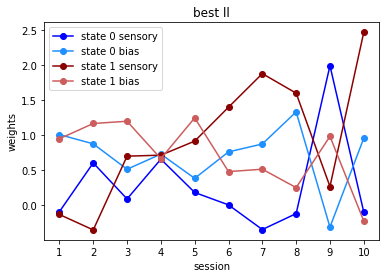

In [37]:
plotting_weights(allW[2,1,2],sessInd,'best ll')